# Import Data

Two (textual) datasets are used for the Phase 1 of this project:


*   [MovieLens-latest-small](https://https://www.kaggle.com/datasets/grouplens/movielens-latest-small) : This dataset is used since it is the most grounded, frequently-used baseline and evaluation guide. It has `movies.csv` with simple movie data such as id, title and genres.`ratings.csv` is the backbone for our recommendation syste, especially if we want to build a user-based recommender system, and it will be used as a baseline, combined with TMDb dataset average ratings(its rating is in a range of 10, while MovieLens has user ratings on a range of 5. `tags.csv` includes additional info which is useful for enhancing our recommender system with additional data, such as most highlighted features of a movie. `links.csv` will be used for further improvements, when we want to link our movies to TMDb dataset's poster information . This is useful for multimodal recommender systems.
*   [Tmdb-5000](https://https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata): This dataset is highly comprehensive and has pre-calculated average rating data which we want to use in our ranking system. Also, it is richer in metadata such as plot, crew, cast, director, original title and many more. You can check the link for more information. `credits.csv` is used for using cast, crew and director data.

* id (TMDb id) — used to join with MovieLens links.csv → tmdbId.

* title /original_title — fallback text and sanity checks.

* overview — the central text feature (plot summary). Used to build TF–IDF / SBERT embeddings.

* tagline— short catchy text that can sometimes improve similarity for certain films.

* genres — include as both structured features and appended text.

* release_date — useful for time-based filtering and as a feature (recency).

* vote_average and vote_count — use as item metadata: compute the weighted (Bayesian) score and use vote_count as confidence. Do not use vote_average as a substitute for MovieLens ratings.

* popularity — TMDb’s internal popularity score (useful for tie-breaking or re-ranking).

* original_language, runtime, keywords (if available), credits.cast (top-5 names) — optional metadata that can be appended to textual representation if richer signals are wanted.



In [3]:
import pandas as pd
import kagglehub

In [4]:
# Load MovieLens data
# movielens100k(small) :  It contains 100836 ratings and 3683 tag applications across 9742 movies
path = kagglehub.dataset_download("grouplens/movielens-latest-small")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/movielens-latest-small


In [5]:
movie_data = pd.read_csv('/kaggle/input/movielens-latest-small/movies.csv')
ratings = pd.read_csv('/kaggle/input/movielens-latest-small/ratings.csv')
tags = pd.read_csv('/kaggle/input/movielens-latest-small/tags.csv')
# links.csv is for further use, such as hybrid system or multimodal systems to link TMDb dataset with poster (visual) data.

## Exploratory Data Analysis (EDA)

In [6]:
movie_data

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [7]:
movie_data.columns

Index(['movieId', 'title', 'genres'], dtype='object')

In [8]:
movie_data.info()
movie_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [9]:
# use for training/evaluation only
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [10]:
ratings.info()
ratings.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [11]:
# Load TMDb 5000 Dataset
path = kagglehub.dataset_download("tmdb/tmdb-movie-metadata")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tmdb-movie-metadata


In [12]:
tmdb_data = pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv')
tmdb_data2=pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_credits.csv')

In [13]:
tmdb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [14]:
print(tmdb_data.isnull().sum())
print("------------------------")
print(tmdb_data2.isnull().sum())

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64
------------------------
movie_id    0
title       0
cast        0
crew        0
dtype: int64


In [15]:
tmdb_data["tagline"]

0                             Enter the World of Pandora.
1          At the end of the world, the adventure begins.
2                                   A Plan No One Escapes
3                                         The Legend Ends
4                    Lost in our world, found in another.
                              ...                        
4798    He didn't come looking for trouble, but troubl...
4799    A newlywed couple's honeymoon is upended by th...
4800                                                  NaN
4801                             A New Yorker in Shanghai
4802                                                  NaN
Name: tagline, Length: 4803, dtype: object

In [16]:
tags.info()
tags["tag"]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


0                  funny
1        Highly quotable
2           will ferrell
3           Boxing story
4                    MMA
              ...       
3678           for katie
3679             austere
3680              gun fu
3681    heroic bloodshed
3682    Heroic Bloodshed
Name: tag, Length: 3683, dtype: object

In [17]:
titles_with_no_tagline = tmdb_data[tmdb_data["tagline"].isnull()]["title"]
print(titles_with_no_tagline)

10                  Superman Returns
56                  Star Trek Beyond
66                                Up
78                   The Jungle Book
128                  Angels & Demons
                    ...             
4790                      The Circle
4794    Sanctuary: Quite a Conundrum
4797                          Cavite
4800       Signed, Sealed, Delivered
4802               My Date with Drew
Name: title, Length: 844, dtype: object


In [18]:
# Merge movies and tags on ID
common = pd.merge(tmdb_data, tags, left_on="id", right_on="movieId")

common[['title', 'tag', 'tagline', 'overview']].head(5)


,title,tag,tagline,overview
0,Pirates of the Caribbean: Dead Man's Chest,writing,Jack is back!,Captain Jack Sparrow works his way out of a bl...
1,The Golden Compass,court,There are worlds beyond our own - the compass ...,"After overhearing a shocking secret, precociou..."
2,The Golden Compass,military,There are worlds beyond our own - the compass ...,"After overhearing a shocking secret, precociou..."
3,Titanic,prostitution,Nothing on Earth could come between them.,"84 years later, a 101-year-old woman named Ros..."
4,Terminator Salvation,C.S. Lewis,The End Begins.,"All grown up in post-apocalyptic 2018, John Co..."


In [19]:
print(common['overview'].iloc[3])

84 years later, a 101-year-old woman named Rose DeWitt Bukater tells the story to her granddaughter Lizzy Calvert, Brock Lovett, Lewis Bodine, Bobby Buell and Anatoly Mikailavich on the Keldysh about her life set in April 10th 1912, on a ship called Titanic when young Rose boards the departing ship with the upper-class passengers and her mother, Ruth DeWitt Bukater, and her fiancé, Caledon Hockley. Meanwhile, a drifter and artist named Jack Dawson and his best friend Fabrizio De Rossi win third-class tickets to the ship in a game. And she explains the whole story from departure until the death of Titanic on its first and last voyage April 15th, 1912 at 2:20 in the morning.


Since I do not want to lose important data (some of these movies are really good!) , I want to replicate NaN values with the help of an LM - therefore also practicing data augmentation.

## Data Augmentation with the help of an LM

In [21]:
missing_taglines = tmdb_data[tmdb_data["tagline"].isnull()]

In [ ]:
'''from transformers import pipeline
import torch

# Load LLaMA 3.2 (3B Instruct)
generator = pipeline(
    "text-generation",
    model="meta-llama/Llama-3.2-3B-Instruct",
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
    token=access_token
)

def generate_tagline(title, overview, tag=None, max_length=20):
    # Build the prompt in an instruction style
    prompt = (
        "You are a creative movie marketer.\n"
        "Write a single, catchy, one-sentence movie tagline based on the info below.\n"
        "Return only the tagline.\n\n"
        f"Title: {title}\n"
        f"Overview: {overview}\n"
    )
    if tag:
        prompt += f"Genre/Tag: {tag}\n"
    prompt += "\nTagline:"

    # Generate with LLaMA
    outputs = generator(
        prompt,
        max_new_tokens=50,
        do_sample=True,
        temperature=0.8,
        top_p=0.9,
    )

    # Extract text
    tagline = outputs[0]["generated_text"]

    # Clean up: cut off before/after the "Tagline:" marker
    if "Tagline:" in tagline:
        tagline = tagline.split("Tagline:", 1)[1].strip()


    return tagline

'''

2025-09-30 12:24:05.996237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759235046.391523      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759235046.498082      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Device set to use cuda:0


In [29]:
# Fill missing taglines
for idx, row in missing_taglines.iterrows():
    movie_id = row["id"]

    # Check if a tag exists for this movie in the 'common' DataFrame
    existing_tags = common[common["id"] == movie_id]["tag"].dropna().tolist()

    if existing_tags:
        # Take the first tag as inspiration, or do something else with the list
        tag = existing_tags[0]
    else:
        tag = ""

    generated = generate_tagline(row["title"], row["overview"],tag )
    tmdb_data.at[idx, "tagline"] = generated

print("Missing taglines generated successfully!")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_to

Missing taglines generated successfully!


In [30]:
print(tmdb_data.isnull().sum())

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                    0
title                      0
vote_average               0
vote_count                 0
dtype: int64


In [31]:
for title in missing_taglines["title"]:
    example = tmdb_data[tmdb_data["title"] == title]
    # Now print the tagline
    print(example[['tagline','title']])

                                tagline             title
10  "When heroes sleep, villains rise."  Superman Returns
                                    tagline             title
56  "Beyond the stars, a new enemy awaits."  Star Trek Beyond
                                     tagline title
66  "Adventure just landed on his doorstep."    Up
                                              tagline            title
78  "The wild will always be his home, no matter w...  The Jungle Book
                                        tagline            title
128  "Uncover the secrets, ignite the inferno."  Angels & Demons
                                               tagline                  title
166  "The only enemy they can't terminate is themse...  G.I. Joe: Retaliation
                                               tagline  \
235  "The gods may be watching, but only one team c...   

                            title  
235  Asterix at the Olympic Games  
                                         

In [38]:
# so that we do not run the model every time
#tmdb_data.to_csv("/kaggle/working/tmdb_data_with_taglines.csv", index=False) 

In [85]:
# Replace the path : 
tmdb_data = pd.read_csv('/kaggle/working/tmdb_data_with_taglines.csv')

## Continue EDA & Handle Missing Values
Great! Now our populated database looks fine to use, as the generated taglines appear appropriate enough. We can inspect more.

In [86]:
# This column consists of many URLs that will be not used for our project, and has many null values. It can be safely dropped
tmdb_data = tmdb_data.drop(columns='homepage')

In [87]:
# Check the type of the column itself
print(type(tmdb_data['genres']))

<class 'pandas.core.series.Series'>


In [88]:
import ast  

# Convert string to list of dicts
tmdb_data['genres'] = tmdb_data['genres'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

# Extract genre names
tmdb_data['genre_names'] = tmdb_data['genres'].apply(lambda lst: [g['name'] for g in lst])

# Explode lists into rows
all_genres = tmdb_data['genre_names'].explode()

# Count the most frequent genres
top_10_genres = all_genres.value_counts().head(10)
print(top_10_genres)


genre_names
Drama              2297
Comedy             1722
Thriller           1274
Action             1154
Romance             894
Adventure           790
Crime               696
Science Fiction     535
Horror              519
Family              513
Name: count, dtype: int64


In [89]:
# Recall that we have 3 movies with null overview values
null_overview_movies = tmdb_data[tmdb_data['overview'].isnull()]

# Display the result
print(null_overview_movies["title"])


2656    Chiamatemi Francesco - Il Papa della gente
4140                   To Be Frank, Sinatra at 100
4431                                   Food Chains
Name: title, dtype: object


In [90]:
# Overview is an important field that we will use later for recommendation, 
# to prevent it from affecting our similarity metrics, we drop the null values
tmdb_data = tmdb_data.dropna(subset=['overview'])

In [91]:
tmdb_data['overview'].isnull().sum()

0

In [92]:
# same for the 1 null release_date value
tmdb_data = tmdb_data.dropna(subset=['release_date'])
tmdb_data['release_date'].isnull().sum()

0

In [93]:
tmdb_data.columns

Index(['budget', 'genres', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'genre_names'],
      dtype='object')

In [94]:
# Filter movies where status is not "Released"
not_released_movies = tmdb_data[tmdb_data["status"] != "Released"]

# Display them
print(not_released_movies["status"])


2906    Post Production
4169    Post Production
4178    Post Production
4401            Rumored
4453            Rumored
4508            Rumored
4662            Rumored
4754            Rumored
Name: status, dtype: object


In [96]:
print(not_released_movies["revenue"])

2906         0
4169         0
4178    841733
4401         0
4453         0
4508         0
4662         0
4754         0
Name: revenue, dtype: int64


After some inspection of the columns, I decided to keep the existing columns, as the fields such as status, production_company, spoken_languages, and production_countries could be important factors for people to watch a movie.

## Join Two Tables with Important Info
As cast and crew(director name) are crucial factors for most of the people to choose movies, I will merge two datasets:

In [97]:
tmdb_data2.columns = ['id','title','cast','crew']
tmdb_data= tmdb_data.merge(tmdb_data2,on='id')

In [98]:
tmdb_data.columns

Index(['budget', 'genres', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'genre_names', 'title_y', 'cast', 'crew'],
      dtype='object')

In [99]:
tmdb_data = tmdb_data.drop('title_y', axis=1).rename(columns={'title_x':'title'})


In [103]:
tmdb_data[['title','cast','crew']].head(5)

,title,cast,crew
0,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [105]:
tmdb_data.isnull().sum()

budget                  0
genres                  0
id                      0
keywords                0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
tagline                 0
title                   0
vote_average            0
vote_count              0
genre_names             0
cast                    0
crew                    0
dtype: int64

### **Rating**

In [106]:

C= tmdb_data['vote_average'].mean()

# For a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.
m= tmdb_data['vote_count'].quantile(0.9)


def weighted_rating(x, m=m, C=C):
  '''Calculates the weighted rating for a movie based on the IMDB formula.

  Args:
      x (pd.Series): A row of the dataframe containing 'vote_count' and 'vote_average'.
      m (float): The minimum number of votes required to be listed in the chart.
      C (float): The mean vote across the dataset.

  Returns:
      float: The weighted rating score.
  '''
  # The number of votes received by the movie.
  v = x['vote_count']
  # The average rating for the movie.
  R = x['vote_average']
  # Calculation based on the IMDB formula
  return (v/(v+m) * R) + (m/(m+v) * C)

In [107]:
q_movies = tmdb_data.copy().loc[tmdb_data['vote_count'] >= m]

# After omitting the movies above the vote count trreshold, we get 480 movies
q_movies.shape

(480, 22)

In [108]:
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)


# 1. Demographic-Based Simple Filtering
This offers generalized recommnendations to every user based on movie popularity and (sometimes) genre. The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience. This model does not give personalized recommendations based on the user.

The implementation of this model is extremely trivial. We sort our movies based on ratings and popularity and display the top movies of our list. As an added step, we can pass in a genre argument to get the top movies of a particular genre.

In [109]:
# SORTING BASED ON SCORE

# Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

# Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.058883
662,Fight Club,9413,8.3,7.938962
65,The Dark Knight,12002,8.2,7.919787
3231,Pulp Fiction,8428,8.3,7.904336
96,Inception,13752,8.1,7.863046
3336,The Godfather,5893,8.4,7.850852
95,Interstellar,10867,8.1,7.809257
809,Forrest Gump,7927,8.2,7.802902
329,The Lord of the Rings: The Return of the King,8064,8.1,7.726990
1990,The Empire Strikes Back,5879,8.2,7.697574


Text(0.5, 1.0, 'Popular Movies')

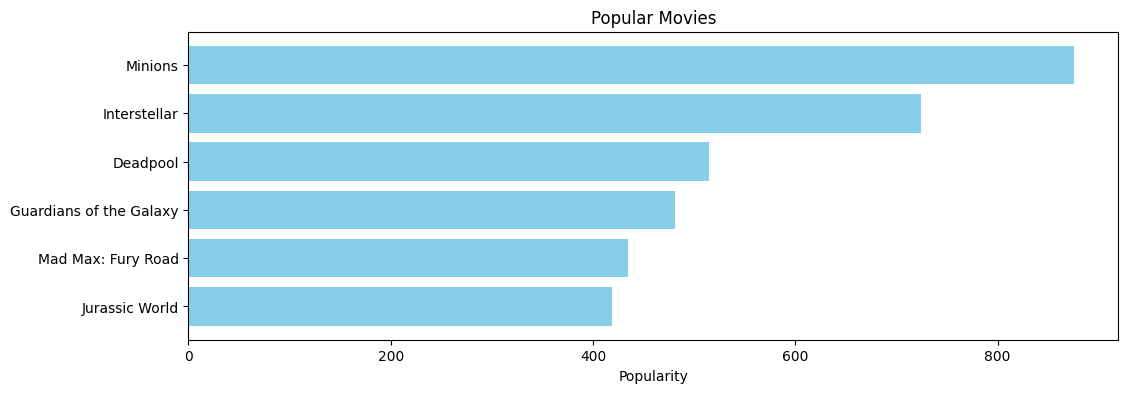

In [110]:
pop= tmdb_data.sort_values('popularity', ascending=False)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

# 2. Content Based Filtering


In [111]:
# Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

# Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(tmdb_data['overview'])

# Output the shape of tfidf_matrix
tfidf_matrix.shape

(4799, 20977)

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the cosine similarity scores. There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics. These experiments can be found in following sections:

## 2.1. Cosine Similarity

In [112]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [113]:
# Construct a reverse map of indices and movie titles
indices = pd.Series(tmdb_data.index, index=tmdb_data['title']).drop_duplicates()

In [114]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title,sim_matrix,indices):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(sim_matrix[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return tmdb_data['title'].iloc[movie_indices]

In [115]:
get_recommendations('The Dark Knight Rises',cosine_sim,indices)


65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3853    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [116]:
get_recommendations('Blade Runner',cosine_sim,indices)


3348        Desperado
44          Furious 7
1056            Blade
4499    Water & Power
4666          Mad Max
2001         The Crew
2383    The Informers
3197     Undiscovered
642          Unbroken
376           Volcano
Name: title, dtype: object

### 2.1.1. Recommendation based on Director, Cast Members and Genre




In [117]:
import numpy as np

In [118]:
tmdb_data.head(2)

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,genre_names,cast,crew
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[Action, Adventure, Fantasy, Science Fiction]","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[Adventure, Fantasy, Action]","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [121]:
tmdb_data.head(2)


,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,genre_names,cast,crew
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[Action, Adventure, Fantasy, Science Fiction]","[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de..."
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[Adventure, Fantasy, Action]","[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de..."


In [122]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [123]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [124]:
# Define new director, cast, genres and keywords features that are in a suitable form.
tmdb_data['director'] = tmdb_data['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    tmdb_data[feature] = tmdb_data[feature].apply(get_list)

In [125]:
tmdb_data[['title', 'cast', 'director', 'keywords', 'genres']].head(3)


,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [126]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [127]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    tmdb_data[feature] = tmdb_data[feature].apply(clean_data)

In [129]:
def create_metadata(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
tmdb_data['key_metadata'] = tmdb_data.apply(create_metadata, axis=1)

The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the CountVectorizer() instead of TF-IDF. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies.

In [130]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(tmdb_data['key_metadata'])

In [131]:
# Compute the Cosine Similarity matrix based on the count_matrix
cosine_sim2 = linear_kernel(count_matrix, count_matrix)

In [132]:
# Reset index of our main DataFrame and construct reverse mapping as before
tmdb_data = tmdb_data.reset_index(drop=True)
indices = pd.Series(tmdb_data.index, index=tmdb_data['title'])

In [133]:
get_recommendations('The Dark Knight Rises', cosine_sim2,indices)


65                     The Dark Knight
119                      Batman Begins
1196                      The Prestige
3072                 Romeo Is Bleeding
72                       Suicide Squad
82      Dawn of the Planet of the Apes
157             Exodus: Gods and Kings
210                     Batman & Robin
280                     Public Enemies
299                     Batman Forever
Name: title, dtype: object

In [134]:
get_recommendations('Blade Runner', cosine_sim2,indices)


93     Terminator 3: Rise of the Machines
108                    Terminator Genisys
333                         Transcendence
43                   Terminator Salvation
95                           Interstellar
123                The Matrix Revolutions
125                   The Matrix Reloaded
239                               Gravity
266                              I, Robot
270                           The Martian
Name: title, dtype: object

Now our content-based filtering based on top 3 people on cast, director and genre suggest more relevant movies. For example, for The Dark Knight Rises, not only the movies about Batman shown, but rather more movies with similar plot and director is shown.

### 2.1.2. Recommendation Based on Overview and Taglines

In [135]:
tmdb_data['description_recommend'] = tmdb_data['overview'] + tmdb_data['tagline']


In [136]:
tmdb_data['description_recommend'].isna().sum()

0

In [137]:
tmdb_data.columns

Index(['budget', 'genres', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'genre_names', 'cast', 'crew', 'director', 'key_metadata',
       'description_recommend'],
      dtype='object')

In [138]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=2, stop_words='english')
tfidf_matrix_descriptions = tf.fit_transform(tmdb_data['description_recommend'])
tfidf_matrix_descriptions.shape

(4799, 19657)

In [139]:
# try with CountVectorizer
count1 = CountVectorizer(stop_words='english')
count_matrix1 = count.fit_transform(tmdb_data['description_recommend'])
count_matrix1.shape

(4799, 21796)

In [140]:
cosine_sim3 = linear_kernel(tfidf_matrix_descriptions, tfidf_matrix_descriptions)
cosine_sim_cv = linear_kernel(count_matrix1,count_matrix1)

In [141]:
# Reset index of our main DataFrame and construct reverse mapping as before
tmdb_data = tmdb_data.reset_index(drop=True)
indices = pd.Series(tmdb_data.index, index=tmdb_data['title'])


In [142]:
get_recommendations('The Dark Knight Rises', cosine_sim3, indices)

299                              Batman Forever
65                              The Dark Knight
428                              Batman Returns
1359                                     Batman
3853    Batman: The Dark Knight Returns, Part 2
2507                                  Slow Burn
119                               Batman Begins
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [143]:
get_recommendations('Blade Runner', cosine_sim3, indices)

376                                               Volcano
3197                                         Undiscovered
4499                                        Water & Power
2157                                          Daybreakers
976                                      Escape from L.A.
763                                           The Soloist
480                                     Battlefield Earth
1056                                                Blade
262     The Lord of the Rings: The Fellowship of the Ring
3826                                               Friday
Name: title, dtype: object

For the Dark Knight Rises, the listing of movies slightly changed while for Blade Runner the movie list completely diverged from the previous ones (cosine similarity on overview & cosine similarity on cast,crew,genre) . Now let's try CountVectorizer:

In [144]:
# Reset index of our main DataFrame and construct reverse mapping as before
tmdb_data = tmdb_data.reset_index(drop=True)
indices = pd.Series(tmdb_data.index, index=tmdb_data['title'])


In [145]:
get_recommendations('The Dark Knight Rises', cosine_sim_cv, indices)

299                   Batman Forever
428                   Batman Returns
1984       The Thief and the Cobbler
65                   The Dark Knight
238     Teenage Mutant Ninja Turtles
1359                          Batman
3941             Hobo with a Shotgun
119                    Batman Begins
160       How to Train Your Dragon 2
307                The Expendables 3
Name: title, dtype: object

In [146]:
get_recommendations('Blade Runner', cosine_sim_cv, indices)

3595    Y Tu Mamá También
1316             Precious
3781          Holy Motors
3153                Kites
3471              Pollock
222               Elysium
376               Volcano
943              Firewall
962         Raising Helen
969             Assassins
Name: title, dtype: object

Now we have rarer results than the previous ones. For The Dark Knight Rises, it is obviously seen that genres diverged a lot, while for Blade Runner I cannot evaluate similarity that much since I am not familiar with the movies

### 2.1.3. Filtering Based on Popularity and Ratings
To improve our results and get more relevant, or more likely to be preferred movies, we apply a filtering based on popularity and average ratings.

In [150]:
def improved_recommendations(title,sim_matrix,indices):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(sim_matrix[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:26]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]


    movies = tmdb_data.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'release_date']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[
      (movies['vote_count'] >= m) &
      (movies['vote_count'].notnull()) &
      (movies['vote_average'].notnull())
    ].copy()

    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)


    return qualified

In [151]:
# Reset index of our main DataFrame and construct reverse mapping as before
tmdb_data = tmdb_data.reset_index(drop=True)
indices = pd.Series(tmdb_data.index, index=tmdb_data['title'])


In [152]:
improved_recommendations('The Dark Knight Rises',cosine_sim,indices)


,title,vote_count,vote_average,release_date,wr
65,The Dark Knight,12002,8,2008-07-16,7.746400
119,Batman Begins,7359,7,2005-06-10,6.818644
790,American Sniper,4469,7,2014-12-11,6.735599
1359,Batman,2096,7,1989-06-23,6.576281
879,Law Abiding Citizen,1486,7,2009-10-15,6.498621
1068,The Hitchhiker's Guide to the Galaxy,1315,6,2005-01-15,6.054957
428,Batman Returns,1673,6,1992-06-19,6.049360
299,Batman Forever,1498,5,1995-05-31,5.603470
9,Batman v Superman: Dawn of Justice,7004,5,2016-03-23,5.227862
210,Batman & Robin,1418,4,1997-06-20,5.183335


In [153]:
# Reset index of our main DataFrame and construct reverse mapping as before
tmdb_data = tmdb_data.reset_index(drop=True)
indices = pd.Series(tmdb_data.index, index=tmdb_data['title'])


In [154]:
improved_recommendations('The Dark Knight Rises',cosine_sim2,indices)


,title,vote_count,vote_average,release_date,wr
65,The Dark Knight,12002,8,2008-07-16,7.746400
1196,The Prestige,4391,8,2006-10-19,7.436744
119,Batman Begins,7359,7,2005-06-10,6.818644
82,Dawn of the Planet of the Apes,4410,7,2014-06-26,6.733104
510,Children of Men,2071,7,2006-09-22,6.573574
405,The Fast and the Furious: Tokyo Drift,1705,6,2006-06-03,6.048915
747,Gangster Squad,1778,6,2013-01-10,6.047928
739,London Has Fallen,1621,5,2016-03-02,5.582037
157,Exodus: Gods and Kings,1921,5,2014-12-03,5.535637
72,Suicide Squad,7458,5,2016-08-02,5.216738


In [155]:
# Reset index of our main DataFrame and construct reverse mapping as before
tmdb_data = tmdb_data.reset_index(drop=True)
indices = pd.Series(tmdb_data.index, index=tmdb_data['title'])


In [156]:
improved_recommendations('The Dark Knight Rises',cosine_sim3,indices)

,title,vote_count,vote_average,release_date,wr
65,The Dark Knight,12002,8,2008-07-16,7.746400
119,Batman Begins,7359,7,2005-06-10,6.818644
1359,Batman,2096,7,1989-06-23,6.576281
281,American Gangster,1502,7,2007-11-02,6.501020
879,Law Abiding Citizen,1486,7,2009-10-15,6.498621
428,Batman Returns,1673,6,1992-06-19,6.049360
884,Zero Dark Thirty,1702,6,2012-12-19,6.048956
299,Batman Forever,1498,5,1995-05-31,5.603470
9,Batman v Superman: Dawn of Justice,7004,5,2016-03-23,5.227862
210,Batman & Robin,1418,4,1997-06-20,5.183335


In [157]:
# Reset index of our main DataFrame and construct reverse mapping as before
tmdb_data = tmdb_data.reset_index(drop=True)
indices = pd.Series(tmdb_data.index, index=tmdb_data['title'])


In [158]:
improved_recommendations('The Dark Knight Rises',cosine_sim_cv,indices)

,title,vote_count,vote_average,release_date,wr
65,The Dark Knight,12002,8,2008-07-16,7.746400
119,Batman Begins,7359,7,2005-06-10,6.818644
160,How to Train Your Dragon 2,3106,7,2014-06-12,6.662768
1177,Sin City,2691,7,2005-04-01,6.631896
1359,Batman,2096,7,1989-06-23,6.576281
307,The Expendables 3,1795,6,2014-08-04,6.047704
212,The Day After Tomorrow,2392,6,2004-05-26,6.040978
304,Hercules,1680,5,2014-07-23,5.572287
238,Teenage Mutant Ninja Turtles,2636,5,2014-08-07,5.450116
9,Batman v Superman: Dawn of Justice,7004,5,2016-03-23,5.227862


## 2.2. Euclidean Distance
Since it is very similar to cosine similarity, it will be used for a sanity check, with normalization first.

In [159]:
from sklearn.metrics.pairwise import euclidean_distances

tfidf_eucl = TfidfVectorizer(stop_words='english', norm=None)  # no L2 normalization
tfidf_matrix_eucl = tfidf.fit_transform(tmdb_data['overview'])

eucl_dist = euclidean_distances(tfidf_matrix_eucl, tfidf_matrix_eucl)

In [160]:
eucl_sim = 1 / (1 + eucl_dist)

In [161]:
# Reset index of our main DataFrame and construct reverse mapping as before
tmdb_data = tmdb_data.reset_index(drop=True)
indices = pd.Series(tmdb_data.index, index=tmdb_data['title']).to_dict()

In [162]:
get_recommendations('The Dark Knight Rises',eucl_sim,indices)


4399                        The Helix... Loaded
65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3853    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
Name: title, dtype: object

In [163]:
get_recommendations('Blade Runner',eucl_sim,indices)


4399    The Helix... Loaded
3348              Desperado
44                Furious 7
1056                  Blade
4499          Water & Power
4666                Mad Max
2001               The Crew
2383          The Informers
3197           Undiscovered
642                Unbroken
Name: title, dtype: object

In [175]:
eucl_dist2= euclidean_distances(count_matrix, count_matrix)
eucl_sim2 = 1 / (1 + eucl_dist2)

In [177]:
# Reset index of our main DataFrame and construct reverse mapping as before
tmdb_data = tmdb_data.reset_index(drop=True)
indices = pd.Series(tmdb_data.index, index=tmdb_data['title']).to_dict()

In [178]:
get_recommendations('The Dark Knight Rises',eucl_sim2,indices)

65               The Dark Knight
119                Batman Begins
4634    Amidst the Devil's Wings
4067                   Sharkskin
4117      Hum To Mohabbat Karega
4312                   Crowsnest
4455         Harrison Montgomery
4501     Light from the Darkroom
4558    The Little Ponderosa Zoo
4560    Straight Out of Brooklyn
Name: title, dtype: object

In [179]:
eucl_dist3 = euclidean_distances(tfidf_matrix_descriptions, tfidf_matrix_descriptions)
eucl_sim3 = 1 / (1 + eucl_dist3)

In [180]:
# Reset index of our main DataFrame and construct reverse mapping as before
tmdb_data = tmdb_data.reset_index(drop=True)
indices = pd.Series(tmdb_data.index, index=tmdb_data['title']).to_dict()

In [181]:
get_recommendations('The Dark Knight Rises',eucl_sim3,indices)

299                              Batman Forever
65                              The Dark Knight
428                              Batman Returns
1359                                     Batman
3853    Batman: The Dark Knight Returns, Part 2
2507                                  Slow Burn
119                               Batman Begins
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [182]:
eucl_dist4 = euclidean_distances(count_matrix1, count_matrix1)
eucl_sim4 = 1 / (1 + eucl_dist4)

In [183]:
# Reset index of our main DataFrame and construct reverse mapping as before
tmdb_data = tmdb_data.reset_index(drop=True)
indices = pd.Series(tmdb_data.index, index=tmdb_data['title']).to_dict()

In [184]:
get_recommendations('The Dark Knight Rises',eucl_sim4,indices)

1359                                Batman
876                   Domestic Disturbance
584                                   Wolf
1524                 George and the Dragon
3388                 Chairman of the Board
3522                           Khiladi 786
1515                    Laws of Attraction
1704                         The Big Short
2849    Tales from the Crypt: Demon Knight
3197                          Undiscovered
Name: title, dtype: object

## 2.3. Jaccard distance
This method will be used for genre-based similarity.

In [202]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import pairwise_distances
import pandas as pd

mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(tmdb_data['genre_names'])

# Compute Jaccard distance (0 = identical, 1 = completely different)
jaccard_dist = pairwise_distances(genre_matrix, metric='jaccard')
# Convert to similarity
jaccard_sim = 1 - jaccard_dist


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [203]:
# Reset index of our main DataFrame and construct reverse mapping as before
tmdb_data = tmdb_data.reset_index(drop=True)
indices = pd.Series(tmdb_data.index, index=tmdb_data['title']).to_dict()

In [205]:
get_recommendations('The Notebook',jaccard_sim, indices)

463                   Déjà Vu
493          A Beautiful Mind
559              The Majestic
648           Mona Lisa Smile
670             Random Hearts
713       The Horse Whisperer
733       Up Close & Personal
757    Trouble with the Curve
860                 Burlesque
862                    Lolita
Name: title, dtype: object

# 3. Collaborative Filtering

Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.



*   **User based filtering**- These systems recommend products to a user that similar users have liked. For measuring the similarity between two users we can either use pearson correlation or cosine similarity. Although computing user-based CF is very simple, it suffers from several problems. One main issue is that users’ preference can change over time. It indicates that precomputing the matrix based on their neighboring users may lead to bad performance. To tackle this problem, we can apply item-based CF.
*   **Item Based Collaborative Filtering**- Instead of measuring the similarity between users, the item-based CF recommends items based on their similarity with the items that the target user rated. Likewise, the similarity can be computed with Pearson Correlation or Cosine Similarity. The major difference is that, with item-based collaborative filtering, we fill in the blank vertically, as oppose to the horizontal manner that user-based CF does. It successfully avoids the problem posed by dynamic user preference as item-based CF is more static. However, several problems remain for this method. First, the main issue is scalability. The computation grows with both the customer and the product. The worst case complexity is O(mn) with m users and n items. In addition, sparsity is another concern.





## 3.1. Single Value Decomposition
One way to handle the scalability and sparsity issue created by CF is to leverage a latent factor model to capture the similarity between users and items. Essentially, we want to turn the recommendation problem into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. One common metric is Root Mean Square Error (RMSE). The lower the RMSE, the better the performance.

Latent factor is a broad idea which describes a property or concept that a user or an item have. For instance, for music, latent factor can refer to the genre that the music belongs to. SVD decreases the dimension of the utility matrix by extracting its latent factors. Essentially, we map each user and each item into a latent space with dimension r. Therefore, it helps us better understand the relationship between users and items as they become directly comparable.

In [185]:
if int(np.__version__.split('.')[0]) >= 2:
    !pip install "numpy<2" scikit-surprise --force-reinstall
from surprise import Dataset, Reader, SVD


In [186]:
from surprise.model_selection import cross_validate


In [188]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [189]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5)))
svd = SVD()
# Use cross_validate to perform cross-validation
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8845  0.8744  0.8694  0.8676  0.8727  0.8737  0.0059  
MAE (testset)     0.6792  0.6719  0.6715  0.6668  0.6708  0.6720  0.0040  
Fit time          1.10    1.03    1.17    1.00    0.88    1.04    0.10    
Test time         0.10    0.09    0.11    0.54    0.08    0.19    0.18    


{'test_rmse': array([0.88451903, 0.87438823, 0.86941369, 0.8675676 , 0.87268326]),
 'test_mae': array([0.67922775, 0.67185078, 0.67149716, 0.6668435 , 0.67079488]),
 'fit_time': (1.0964314937591553,
  1.028348445892334,
  1.1705353260040283,
  1.0016834735870361,
  0.8843481540679932),
 'test_time': (0.1013021469116211,
  0.08980488777160645,
  0.11365509033203125,
  0.5358736515045166,
  0.08439779281616211)}

In [206]:
trainset = data.build_full_trainset()

svd.fit(trainset)

In [210]:
movie_title="The Dark Knight Rises"
movie_id = tmdb_data.loc[tmdb_data['title'].str.lower() == movie_title.lower(), 'id'].iloc[0]

In [207]:
ratings[ratings['userId'] == 1]


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
227,1,3744,4.0,964980694
228,1,3793,5.0,964981855
229,1,3809,4.0,964981220
230,1,4006,4.0,964982903


In [215]:

svd.predict(1, movie_id, 3) # Predict user's rating for 'The Dark Knight Rises'


Prediction(uid=1, iid=49026, r_ui=3, est=4.242246840355086, details={'was_impossible': False})

## 3.2. Pearson Similarity
Rating-based recommendation from the movies that exist in ratings.csv (collaborative filtering). 

In [253]:
# Compute average rating and number of ratings per movie
movie_stats = ratings.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()

# Optionally, filter movies with at least N ratings to avoid outliers
movie_stats = movie_stats[movie_stats['count'] >= 50]

# Merge with tmdb_data to get titles
movie_stats = movie_stats.merge(movie_data[['movieId', 'title']], on='movieId', how='left')

# Sort by average rating descending
top_movies = movie_stats.sort_values('mean', ascending=False)

# Display top 10
print(top_movies[['title', 'mean', 'count']].head(10))


                                                 title      mean  count
53                    Shawshank Redemption, The (1994)  4.429022    317
118                              Godfather, The (1972)  4.289062    192
277                                  Fight Club (1999)  4.272936    218
171                              Cool Hand Luke (1967)  4.271930     57
112  Dr. Strangelove or: How I Learned to Stop Worr...  4.268041     97
120                                 Rear Window (1954)  4.261905     84
158                     Godfather: Part II, The (1974)  4.259690    129
402                               Departed, The (2006)  4.252336    107
153                                  Goodfellas (1990)  4.250000    126
123                                  Casablanca (1942)  4.240000    100


In [255]:
# Step 1: create user-item rating matrix
rating_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Step 2: compute item-item Pearson correlation
item_similarity = rating_matrix.corr(method='pearson', min_periods=5)


def get_user_cf_recommendations(user_id, rating_matrix, item_similarity, movie_data, top_n=10):
    if user_id not in rating_matrix.index:
        raise ValueError(f"User ID {user_id} not found in rating matrix.")
    
    # Get movies rated by user
    user_ratings = rating_matrix.loc[user_id].dropna()
    
    if user_ratings.empty:
        raise ValueError(f"User ID {user_id} has no ratings.")
    
    # Compute score for each movie based on item similarity
    scores = pd.Series(dtype=float)
    for movie_id, rating in user_ratings.items():
        if movie_id not in item_similarity.columns:
            continue
        sim_movies = item_similarity[movie_id].dropna()
        sim_movies = sim_movies.drop(movie_id, errors='ignore')
        scores = scores.add(sim_movies * rating, fill_value=0)
    
    # Normalize by sum of absolute similarities
    sim_sums = pd.Series(dtype=float)
    for movie_id in user_ratings.index:
        if movie_id not in item_similarity.columns:
            continue
        sim_movies = item_similarity[movie_id].dropna()
        sim_movies = sim_movies.drop(movie_id, errors='ignore')
        sim_sums = sim_sums.add(sim_movies.abs(), fill_value=0)
    
    recommendation_scores = scores / sim_sums
    
    # Exclude movies the user has already rated
    recommendation_scores = recommendation_scores.drop(user_ratings.index, errors='ignore')
    
    # Get top N movie IDs
    top_movie_ids = recommendation_scores.sort_values(ascending=False).head(top_n).index
    
    # Retrieve movie info from movie_data
    top_movies_df = movie_data.set_index('movieId').loc[top_movie_ids]
    
    return top_movies_df[['title', 'genres']]

user_id = 1
top_recommendations = get_user_cf_recommendations(
    user_id=user_id,
    rating_matrix=rating_matrix,
    item_similarity=item_similarity,
    movie_data=movie_data,
    top_n=10
)

print(top_recommendations)


                                                  title  \
movieId                                                   
4090                   Brave Little Toaster, The (1987)   
54648                                Rush Hour 3 (2007)   
175569                                Wind River (2017)   
64                                 Two if by Sea (1996)   
113378                                Giver, The (2014)   
3864     Godzilla 2000 (Gojira ni-sen mireniamu) (1999)   
117851                    Penguins of Madagascar (2014)   
1487                                      Selena (1997)   
102                                    Mr. Wrong (1996)   
26903    Whisper of the Heart (Mimi wo sumaseba) (1995)   

                                      genres  
movieId                                       
4090                      Animation|Children  
54648           Action|Comedy|Crime|Thriller  
175569         Action|Crime|Mystery|Thriller  
64                            Comedy|Romance  
113378   

In [256]:
def get_top_rated_by_user(user_id, ratings_df, movie_data, top_n=10):
    # Filter ratings for the specific user
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    
    if user_ratings.empty:
        raise ValueError(f"User ID {user_id} has no ratings.")
    
    # Sort by rating descending
    top_user_ratings = user_ratings.sort_values(by='rating', ascending=False).head(top_n)
    
    # Merge with movie_data to get titles and genres
    top_movies = top_user_ratings.merge(movie_data, left_on='movieId', right_on='movieId', how='left')
    
    return top_movies[['movieId', 'title', 'genres', 'rating']]

user_id = 1
top_user_movies = get_top_rated_by_user(user_id, ratings, movie_data, top_n=10)
print(top_user_movies)


   movieId                                      title  \
0     2949                              Dr. No (1962)   
1     3703       Road Warrior, The (Mad Max 2) (1981)   
2     3729                               Shaft (1971)   
3     3793                               X-Men (2000)   
4      151                             Rob Roy (1995)   
5      157                      Canadian Bacon (1995)   
6      163                           Desperado (1995)   
7      216                       Billy Madison (1995)   
8      231     Dumb & Dumber (Dumb and Dumber) (1994)   
9      260  Star Wars: Episode IV - A New Hope (1977)   

                             genres  rating  
0         Action|Adventure|Thriller     5.0  
1  Action|Adventure|Sci-Fi|Thriller     5.0  
2       Action|Crime|Drama|Thriller     5.0  
3           Action|Adventure|Sci-Fi     5.0  
4          Action|Drama|Romance|War     5.0  
5                        Comedy|War     5.0  
6            Action|Romance|Western     5.0  
7   

As seen, the ratings of the user and the recommended movies correlate closely. 
- Improvement idea: Hybrid recommender for movies not in ratings.csv (unrated movies), using TMDb weighted rating as a fallback. This ensures the user sees both personalized recommendations and high-quality popular movies they haven’t seen. ( Compute Pearson similarity matrix from ratings.csv. Recommending movies with high similarity for rated movies. For movies not in ratings.csv, using the 'score' field that I previously calculated in the ratings section, including them as fallback (e.g. 70% CF similarity + 30% TMDb weighted rating). This combines personalization (from user ratings) with global quality/popularity (TMDb scores).

# 4. Hybrid Recommender
This system combines both content-based and collaborative filtering approaches. First, it selects movies that are most similar in content to the input movie, based on features such as genres, overview, and tagline. Then, it re-ranks these candidates using predicted ratings from a collaborative filtering model (SVD) tailored to the specific user. 

In [259]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [261]:
links = pd.read_csv('/kaggle/input/movielens-latest-small/links.csv')
id_map = links[['movieId', 'tmdbId']].copy()
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(tmdb_data[['title', 'id']], on='id').set_index('title')

In [262]:
id_map.head(5)

,movieId,id
title,,
Toy Story,1,862.0
GoldenEye,10,710.0
The American President,11,9087.0
Nixon,14,10858.0
Cutthroat Island,15,1408.0


In [263]:
indices_map = id_map.set_index('id')

In [264]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']

    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]

    movies = tmdb_data.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'release_date', 'id']]
    def safe_predict(userId, tmdb_id):
      try:
          movieId = indices_map.loc[tmdb_id]['movieId']
          return svd.predict(userId, movieId).est
      except KeyError:
          # Fallback: no collaborative data → return neutral estimate
          return np.nan
    movies['est'] = movies['id'].apply(lambda x: safe_predict(userId, x))
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [270]:
hybrid(1, 'Dr. No')


,title,vote_count,vote_average,release_date,id,est
4070,From Russia with Love,760,6.9,1963-10-11,657,4.697313
29,Skyfall,7604,6.9,2012-10-25,37724,4.615480
2674,The Spy Who Loved Me,507,6.6,1977-07-07,691,4.594265
3142,You Only Live Twice,531,6.5,1967-06-12,667,4.579070
3335,Diamonds Are Forever,553,6.3,1971-12-13,681,4.543668
3342,Live and Let Die,533,6.4,1973-07-05,253,4.499829
2,Spectre,4466,6.3,2015-10-26,206647,4.424826
2501,Hachi: A Dog's Tale,1717,7.7,2009-06-13,28178,4.388279
3350,The Man with the Golden Gun,524,6.3,1974-12-01,682,4.376510
1717,Safe Haven,823,6.9,2013-02-07,112949,4.370513


In [271]:
hybrid(500, 'Dr. No')


,title,vote_count,vote_average,release_date,id,est
29,Skyfall,7604,6.9,2012-10-25,37724,3.783536
3142,You Only Live Twice,531,6.5,1967-06-12,667,3.677104
3342,Live and Let Die,533,6.4,1973-07-05,253,3.577906
4070,From Russia with Love,760,6.9,1963-10-11,657,3.549660
170,The World Is Not Enough,862,6.0,1999-11-08,36643,3.513938
1131,Licence to Kill,541,5.9,1989-07-07,709,3.462859
1743,Octopussy,527,6.2,1983-06-05,700,3.448956
1717,Safe Haven,823,6.9,2013-02-07,112949,3.399388
695,GoldenEye,1174,6.6,1995-11-16,710,3.291012
3335,Diamonds Are Forever,553,6.3,1971-12-13,681,3.285516


# Using Transformers for Movie Recommendation

In [272]:
!pip install sentence_transformers


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [273]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F


In [275]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)



In [276]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [279]:
def get_embeddings(sentences):
    encoded_input = tokenizer(sentences, padding = True, truncation = True, return_tensors = 'pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    sentence_embeddings = F.normalize(sentence_embeddings, p = 2, dim = 1)
    return sentence_embeddings

In [280]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
movies_embeddings = model.encode(tmdb_data['key_metadata'].tolist())
# movies_embeddings = model.encode(tmdb_data['description_recommend'].tolist())

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/150 [00:00<?, ?it/s]

In [283]:
def get_recommendations_transformer(query, embeddings, df, top_n = 10):
    query_embedding = model.encode([query])
    similarities = cosine_similarity(query_embedding, embeddings)
    top_indices = similarities[0].argsort()[-top_n:][::-1]
    return df.iloc[top_indices]

In [295]:
# query = "Animated movie about bears that I can watch with kids"
# query = "Movies falling under the comedy and horror genres"
# query = "Funny hindi comedies to watch"
query = "Romantic comedies released in the 1990s"
# query = "Christopher Nolan movies"

recommendations = get_recommendations_transformer(query, movies_embeddings, tmdb_data)
recommendations[['title','release_date','genres']]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,title,release_date,genres
4245,Me You and Five Bucks,2015-07-07,"[romance, comedy, drama]"
703,Two Weeks Notice,2002-12-19,"[romance, comedy]"
1806,Accidental Love,2015-02-10,"[romance, comedy]"
4100,Full Frontal,2002-08-02,"[comedy, drama, romance]"
1980,I Don't Know How She Does It,2011-09-16,"[romance, comedy]"
2621,Whatever Works,2009-06-19,"[comedy, romance]"
4527,Never Again,2002-07-12,"[comedy, romance]"
3845,Ira & Abby,2006-01-01,"[comedy, romance]"
3040,Love Jones,1997-03-14,"[comedy, drama, romance]"
1300,The Ugly Truth,2009-07-24,"[comedy, romance]"


Key Takeaways:
- A better similarity function
- Better metadata tailored according to the query
- Different experiments with different LMs
- Hybrid systems using LM and complex algorithms